In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("../NIDS-v1/NF-UQ-NIDS.csv")
df.describe()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
count,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07
mean,4.124519e+04,8.964758e+03,8.661742e+00,1.932050e+01,3.983727e+03,9.489449e+03,3.562578e+01,1.251652e+01,5.095628e+01,2.163429e+06,2.323360e-01
std,2.108654e+04,1.772082e+04,6.404263e+00,3.504857e+01,1.662256e+05,2.933544e+05,1.901997e+03,5.192708e+02,7.733605e+01,2.142507e+06,4.223221e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.299400e+04,5.300000e+01,6.000000e+00,0.000000e+00,6.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,5.061000e+04,4.430000e+02,6.000000e+00,0.000000e+00,2.320000e+02,1.560000e+02,4.000000e+00,2.000000e+00,2.400000e+01,4.178245e+06,0.000000e+00
75%,5.581700e+04,3.389000e+03,6.000000e+00,7.000000e+00,1.440000e+03,1.873000e+03,9.000000e+00,7.000000e+00,2.700000e+01,4.294858e+06,0.000000e+00
max,6.553500e+04,6.553500e+04,2.550000e+02,2.510000e+02,2.282235e+08,2.432197e+08,1.221043e+06,1.349068e+06,2.230000e+02,4.294967e+06,1.000000e+00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994893 entries, 0 to 11994892
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   IPV4_SRC_ADDR               object 
 1   L4_SRC_PORT                 int64  
 2   IPV4_DST_ADDR               object 
 3   L4_DST_PORT                 int64  
 4   PROTOCOL                    int64  
 5   L7_PROTO                    float64
 6   IN_BYTES                    int64  
 7   OUT_BYTES                   int64  
 8   IN_PKTS                     int64  
 9   OUT_PKTS                    int64  
 10  TCP_FLAGS                   int64  
 11  FLOW_DURATION_MILLISECONDS  int64  
 12  Label                       int64  
 13  Attack                      object 
 14  Dataset                     object 
dtypes: float64(1), int64(10), object(4)
memory usage: 1.3+ GB


# Binary Classification

In [4]:
#X_columns = ['L4_SRC_PORT', 'L4_DST_PORT',
#       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
#       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS']

X_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 
             'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS',
             'FLOW_DURATION_MILLISECONDS']

y_bin = df["Label"]
y = df["Attack"]

X_df = df[X_columns]

print(df["IPV4_SRC_ADDR"].value_counts())
print(df["IPV4_DST_ADDR"].value_counts())

IPV4_SRC_ADDR
172.31.69.25      840864
192.168.1.31      269925
192.168.1.30      268910
192.168.1.36      244364
192.168.1.33      195761
                   ...  
114.221.66.81          1
82.131.176.130         1
118.72.176.181         1
185.19.155.103         1
88.249.220.52          1
Name: count, Length: 75630, dtype: int64
IPV4_DST_ADDR
172.31.0.2         2045759
172.31.69.25        940292
192.168.1.190       287600
192.168.100.3       272805
192.168.1.184       240988
                    ...   
205.251.192.135          1
205.251.198.71           1
52.216.65.75             1
119.136.197.189          1
104.67.71.219            1
Name: count, Length: 27826, dtype: int64


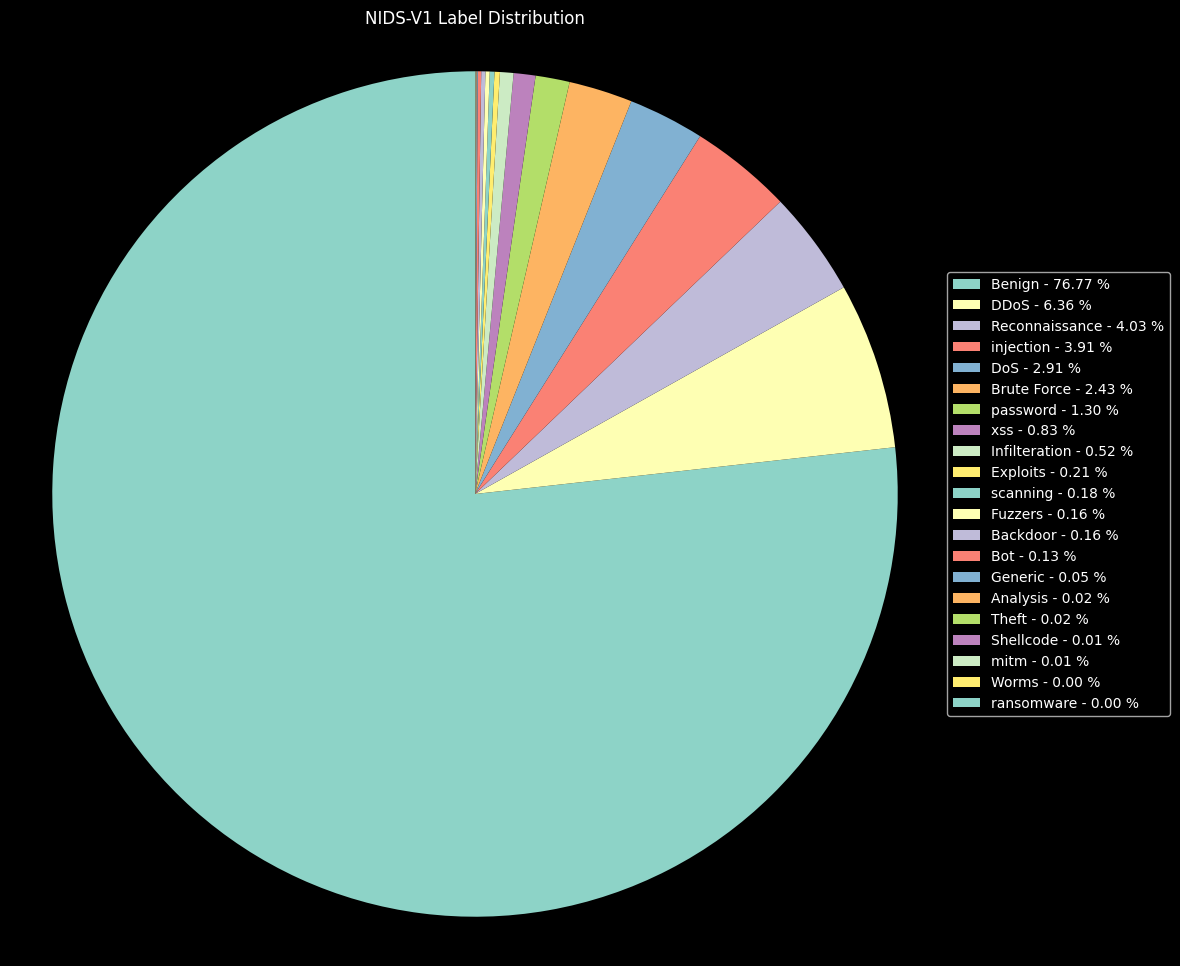

In [7]:
label_series = pd.Series(y.value_counts())

# Get labels and counts from the dictionary
labels = label_series.index
counts = label_series.values
percent = 100.*counts/counts.sum()

# Create a pie chart
plt.figure(figsize=(12, 12))
wedges, _ = plt.pie(counts, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.title('NIDS-V1 Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig('NIDS_label_dist.png', bbox_inches='tight')
plt.show()

In [4]:
# Assuming 'features' is your DataFrame
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column separately
features_scaled = X_df.copy()
for column in X_df.columns:
    column_data = X_df[column].values.reshape(-1, 1)
    features_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
features_scaled.columns = X_df.columns
features_scaled.describe()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
count,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07,1.199489e+07
mean,6.293613e-01,1.367934e-01,3.396761e-02,7.697410e-02,1.745538e-05,3.901596e-05,2.917651e-05,9.277900e-06,2.285035e-01,5.037126e-01
std,3.217599e-01,2.704024e-01,2.511476e-02,1.396357e-01,7.283458e-04,1.206129e-03,1.557682e-03,3.849108e-04,3.467984e-01,4.988414e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.034562e-01,8.087282e-04,2.352941e-02,0.000000e+00,2.979536e-07,0.000000e+00,8.189720e-07,0.000000e+00,8.968610e-03,0.000000e+00
50%,7.722591e-01,6.759747e-03,2.352941e-02,0.000000e+00,1.016547e-06,6.413954e-07,3.275888e-06,1.482505e-06,1.076233e-01,9.728235e-01
75%,8.517128e-01,5.171283e-02,2.352941e-02,2.788845e-02,6.309605e-06,7.700857e-06,7.370748e-06,5.188767e-06,1.210762e-01,9.999746e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [45]:
## GET ALL INFORMATION HERE
print(len(df))
print(len(df.columns))
val_count = df["Label"].value_counts()
print(val_count[1]/val_count[0])

11994893
15
0.3026531790451136


In [50]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_bin, test_size=0.2, random_state=42)

In [51]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 2470.945 seconds.


In [52]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 240.202 seconds.
Classifier predicted on test set in 50.131 seconds.
Accuracy train:  0.995324051466072
Accuracy test:  0.9920628734140648
Precision:  0.9920628734140648
Recall:  0.9920628734140648
F1 Score:  0.9920628734140648


# Non-Binary Classification

In [53]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_labels = y.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# Select n best features based on RF feature importance

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X_df.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

def select_important_features(feature_importance_df_sorted, threshold=0.01):
    important_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > threshold]
    selected_feature_names = important_features['Feature'].tolist()
    return selected_feature_names

# Usage:
selected_features = select_important_features(feature_importance_df_sorted, threshold=0.01)
print("Selected features:", selected_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled[selected_features], encoded_labels, test_size=0.2, random_state=42)

In [ ]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# PCA

In [ ]:
pca = PCA().fit(features_scaled)

fig, ax = plt.subplots( figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis for Digits Dataset')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

# Add a marker at the 95% point
plt.scatter(index_95_percent, 0.95, color='r', marker='o')

# Annotate the point with text
plt.annotate(f'{index_95_percent+1} components\n95% explained variance',
             xy=(index_95_percent, 0.95), xytext=(index_95_percent+20, 0.92),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [ ]:
pca = PCA(n_components=index_95_percent)
pca_result = pca.fit_transform(features_scaled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, y, test_size=0.2, random_state=42)

In [ ]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

In [ ]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Optimal number of components: ", index_95_percent)

In [7]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_binary_labels = y_bin.copy()

# Fit the encoder on the labels and transform the column
encoded_binary_labels = label_encoder.fit_transform(encoded_binary_labels)

In [15]:
encoded_binary_labels

array([0, 0, 0, ..., 0, 0, 5])

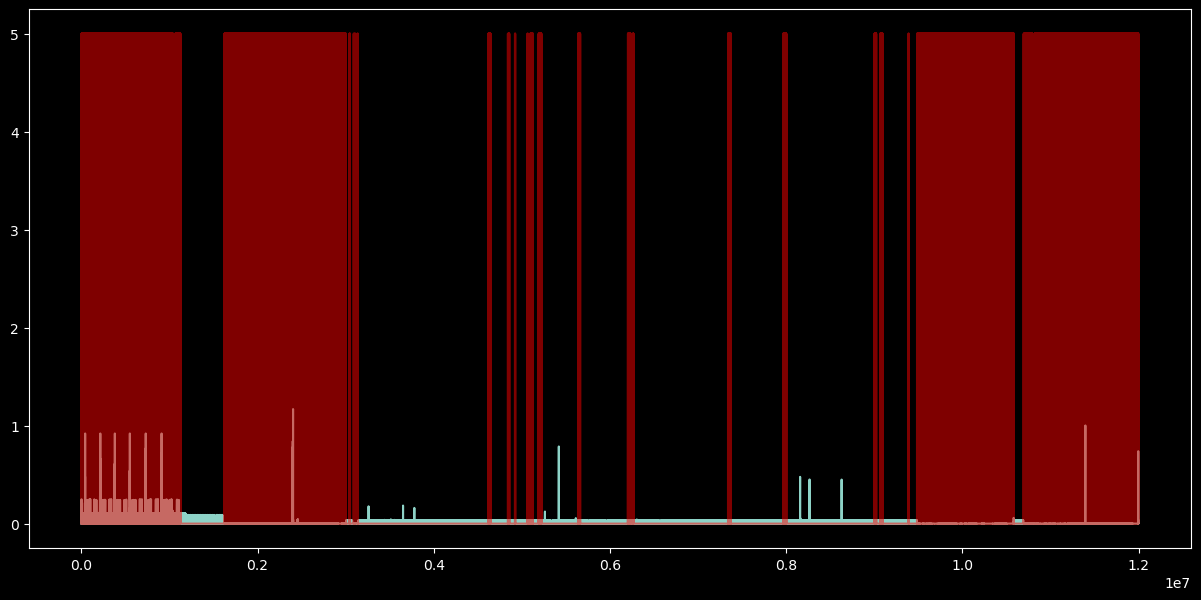

In [14]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.savefig('../images/NIDS_V1_pca_vs_read.png')
plt.show()

In [ ]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=(len(features_scaled.columns)//2), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.savefig('../images/NIDS_V1_pca_vs_read.png')
plt.show()

In [ ]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=(len(features_scaled.columns)//2), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.savefig('../images/NIDS_V1_pca_vs_read.png')
plt.show()